# Homework 3

Jonah Spicher

In [32]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Beta, EstimatedPdf, NormalPdf

import thinkplot
import numpy as np
import pandas as pd
df = pd.read_csv('../data/flea_beetles.csv', delimiter='\t')
pass

### Alien Blaster Problem
The likelihood is determined by the chances of two tests being the same or different. This should give higher likelihoods near extreme hypotheses (The test should always miss if there is a 0% chance of hitting) and smaller likelihoods near the center. This likelihood function seems to reflect that behavior, but only works when two tests (and no more) are performed.

In [3]:
class Blaster_Model(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: two tests were the same or different, 'S' or 'D'
        hypo: probability of hitting a ship
        """
        if data == 'S':
            return 2*(hypo**2) - 2*hypo + 1
        else:
            return 2*hypo - 2*hypo**2

The prior is the beta distribution provided. It has a mean at about 33%.

No handles with labels found to put in legend.


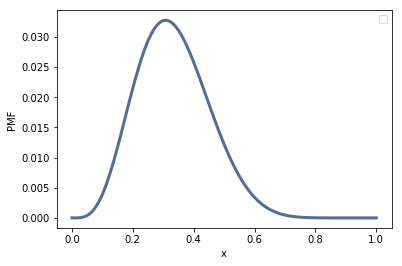

In [3]:
prior = Beta(5, 10)
prior = Blaster_Model(prior.MakePmf())
thinkplot.Plot(prior)
thinkplot.Config(xlabel='x', ylabel='PMF')

Updating given the information that two tests happened, and they were the same, tells us that the weapon is probably slightly worse that even our initial assumption, with a new mean of about 32%.

No handles with labels found to put in legend.


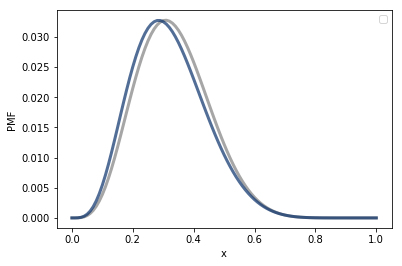

In [4]:
ab9000 = prior.Copy()
ab9000.Update('S')
thinkplot.Plot(prior, color='gray')
thinkplot.Plot(ab9000)
thinkplot.Config(xlabel='x', ylabel='PMF')

In [5]:
print(prior.Mean())
print(ab9000.Mean())

0.33333333317471137
0.31932773078594734


### Flea Beetle Problem
For this problem, the likelihood function requires the distribution of widths and angles for each species. These distributions can be borrowed from the dataframe fairly easily and put into an estimated Pdf, which smooths out the data. The problem implies that a uniform prior is fair, but regardless, the evidence is overwhelmingly in favor of the species "Con."

In [27]:
Condf = df.truncate(0, 20)
Heidf = df.truncate(21, 51)
Hepdf = df.truncate(52, 73)
pass

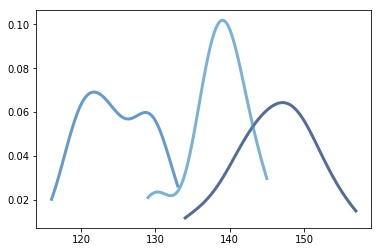

In [28]:
Con_width_dist = EstimatedPdf(Condf.Width)
Con_angle_dist = EstimatedPdf(Condf.Angle)
Hei_width_dist = EstimatedPdf(Heidf.Width)
Hei_angle_dist = EstimatedPdf(Heidf.Angle)
Hep_width_dist = EstimatedPdf(Hepdf.Width)
Hep_angle_dist = EstimatedPdf(Hepdf.Angle)
pass
thinkplot.plot(Con_width_dist)
thinkplot.plot(Hei_width_dist)
thinkplot.plot(Hep_width_dist)

In [8]:
class Beetle(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: width and angle
        hypo: species
        """
        a, w = data
        #Return likelihood that it is each species given width and angle
        if hypo == 'Con':
            like = Con_width_dist.Density(w)*Con_angle_dist.Density(a)
        elif hypo == 'Hei':
            like = Hei_width_dist.Density(w)*Hei_angle_dist.Density(a)
        elif hypo == 'Hep':
            like = Hep_width_dist.Density(w)*Hep_angle_dist.Density(a)
        return float(like)

0.9979586458394037


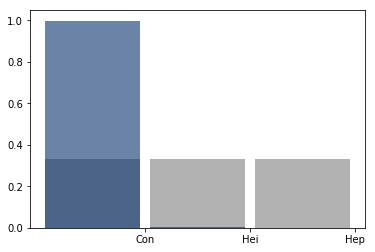

In [9]:
mystery_beetle = Beetle(['Con', 'Hei', 'Hep'])
thinkplot.Hist(mystery_beetle, color='grey')
mystery_beetle.Update((15, 140))
thinkplot.Hist(mystery_beetle)
print(mystery_beetle['Con'])

### The Grizzly Bear Problem
I definitely do not know how to do this problem. If I have time, I will implement my best guess, which I know is at least a little wrong, but will give...some sort of answer.


So, first, the distribution of possible probabilities that a bear is captured. In an actual solution, this would probably be updated by the trapping data, as it depends on what we think about the total bear population. As of right now, it is even for possible values, but obviously cannot be too high or low given the bounds on bear population we were given.

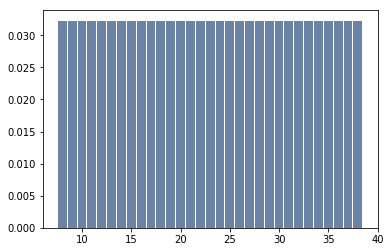

In [39]:
import math

total_captured = 15+23
min_bears = 100
max_bears = 500
prob_captured = Pmf(range(math.ceil(total_captured/5),(total_captured+1)))
thinkplot.Hist(prob_captured)

And now, the other reason I know this solution is wrong. In order to pull it off, I have to make a completely random guess as to what the standard distribution for the distribution of possible percentages of bears captured was. 

My approach here was to say that given the number of bears we captured and an assumed total number of bears, we can find the percentage of bears. Then, we can say that for a given probability of any bear being caught in the trap, there is some normal distribution of how many bears actually get caught in the trap. We can define that normal distribution for percentages, then work it out for each possible value for the probability of capture. The weighted sum of these values should be the total probability of that percentage, and thus that total number of bears. Because we assumed an even prior for prob_capture, we don't need to weight the sum, but I am going to in case I figure out a way to adapt this to work.

Also, I do technically account for the fact that we saw some bears twice, but I bet I do it wrong.

In [46]:
RANDOM_GUESS = 5
class Bear_pop(Suite):
    def Likelihood(self, data, hypo):
        """
        data: number of bears capture once, number of bears captured twice
        hypo: total number of bears
        """
        num1, num2 = data
        total = 0
        #print(prob_captured)
        for p, prob in prob_captured.Items():
            current_dist = NormalPdf(p, RANDOM_GUESS)
            other_dist = NormalPdf(p**2, RANDOM_GUESS)
            
            perc_captured = (num1/hypo)*100 #because the prob_captured distribution is in integers
            perc_c2 = (num2/hypo)*100
            like_given_p = current_dist.Density(perc_captured) + other_dist.Density(perc_c2)
            total += like_given_p
        return total

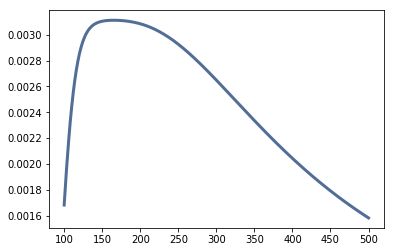

In [47]:
prior = Bear_pop(range(100, 501))
post = prior.Copy()
post.Update((38, 4))
thinkplot.plot(post)

In [48]:
post.Mean()

279.4617715431319

In [49]:
post.MAP()

165

So there is an answer, but I am basically certain it is wrong.

### World Cup Part 2
Because germany is now playing a different team, we can't use the same λ, and we have to use the prior distribution from the first problem. Both teams should have the same prior.

1.310359949002256

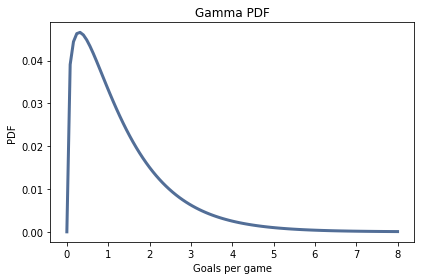

In [9]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
prior = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.decorate(title='Gamma PDF',
                   xlabel='Goals per game',
                   ylabel='PDF')
prior.Mean()

In [10]:
class Soccer(Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: scoring rate in goals per game
        data: interarrival time in minutes
        """
        lam = hypo
        x = data/90
        return lam*np.exp(-1*lam*x)

Here, I sort of guessed that we could use the same model as in the first problem if we just give time intervals which would lead to this number of goals scored. This will only be an approximation, as there are several numbers of goals which could result in 1 or 0 scores.

1.5215720013432537 1.1442797007601064


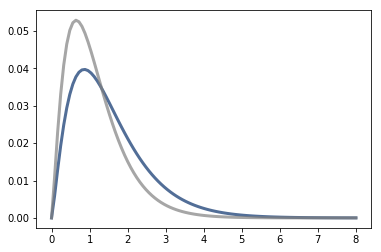

In [14]:
germany = Soccer(prior)
argentina = Soccer(prior)
germany.Update(46)
argentina.Update(91)
print(germany.Mean(), argentina.Mean())
thinkplot.plot(germany)
thinkplot.plot(argentina, color='grey')

### Red Dice Problem
This problem is very similar to the urns problem we worked out in class a few weeks ago. We can find the probability that the next die is red just by updating an even prior once and then summing the total probabilities which could lead to a red die roll. There are two situations which could lead to a red face up, and we need a weighted sum of the two outcomes.

In [19]:
class Red_Dice(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: 'R' or 'B'
        hypo: which die was rolled
        """
        prob_red = 0.333 if hypo == '1' else 0.666
        if data == 'R':
            return prob_red
        else:
            return 1-prob_red

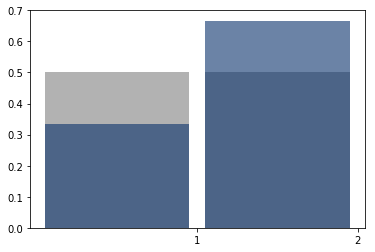

In [23]:
dice = Red_Dice(['1', '2'])
thinkplot.Hist(dice, color='grey')
dice.Update('R')
thinkplot.Hist(dice)

In [25]:
total = 0
for i, prob_i in dice.Items():
    prob_red = 0.333 if i == '1' else 0.666
    total += prob_i * prob_red
    
total

0.555